# Copyright Netherlands eScience Center <br>
** Function     : Extended Range Sea Ice Forecast in the Arctic with ConvLSTM ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.10.04 ** <br>
** Last Update  : 2019.10.04 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, deepclim, matplotlib **<br>
Description     : This notebook serves as an user case of the python package - deepclim. It predicts the Arctic sea ice using deep learning. The convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. <br>
<br>
** Here we predict sea ice concentration with the Arctic sea ice concentration data from ERA-Interim, which is one of the state of the art ECMWF reanalyses datasets used by meteorologists. ** <br>

We use the CPU version code in this demo. In order to reduce the memory usage, we only focus on the Barents sea instead of the entire Arctic.

Return Values   : Time series and figures <br>

The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [1]:
%matplotlib inline

import sys
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import torch
import torch.nn.functional

# append the path of your library
#sys.path.append('/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/Scripts/DeepClim')
sys.path.append('../../DeepClim')
import deepclim
import deepclim.preprocess
import deepclim.deepSeries
import deepclim.deepArray_CPU

# for visualization
import deepclim.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2016 (ECMWF)

Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **ORAS4**       1958 - 2016 (ECMWF)
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Index ** <br>
- **NINO3.4**     1950 - 2017 (NOAA)
- **AO**          1950 - 2017 (NOAA)
- **NAO**         1950 - 2017 (NOAA)
- **AMO**         1950 - 2017 (NOAA)
- **PDO**         1950 - 2017 (University of Washington)

!! These index are given by NCEP/NCAR Reanalysis (CDAS) <br>

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim'
#datapath_ERAI = 'C:\\Path2Data\\ERA-Interim'
output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Maps/Barents/Demo'
#output_path = 'C:\\Path2Output'

In [4]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    # weekly variables on ERAI grid
    dataset_ERAI_fields_sic = Dataset(os.path.join(datapath_ERAI,
                                      'sic_weekly_erai_1979_2017.nc'))
    print ('*********************** extract variables *************************')
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    # we use time series from 2006 to 2016 (11 years, 132 months in total)
    # training data: 2006 - 2014
    # cross validation: 0 (0%)
    # testing data: 2015 - 2016 (20%)
    # variables list:
    # SIC (ERA-Interim)
    # *************************************************************************************** #
    # SIC (ERA-Interim)
    SIC_ERAI = dataset_ERAI_fields_sic.variables['sic'][27:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI = dataset_ERAI_fields_sic.variables['year'][27:-1]
    week_ERAI = dataset_ERAI_fields_sic.variables['week'][:]
    latitude_ERAI = dataset_ERAI_fields_sic.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_sic.variables['longitude'][:]

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [6]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / 480
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:])):
        # change the unit to terawatt
        SIC_ERAI_area[:,:,i,:] = SIC_ERAI[:,:,i,:]* dx[i] * dy / 1E+6 # unit km2
    SIC_ERAI_area[SIC_ERAI_area<0] = 0 # switch the mask from -1 to 0
    print ('================  reshape input data into time series  =================')
    SIC_ERAI_area_series = deepclim.preprocess.operator.unfold(SIC_ERAI_area)

******************  calculate extent from spatial fields  *******************
================  reshape input data into time series  =================


In [7]:
    print ('******************  choose the fields from target region  *******************')
    # select land-sea mask
    #################################################################################
    ###########                 global land-sea mask                      ###########
    #################################################################################
    sea_ice_mask_global = np.ones((len(latitude_ERAI),len(longitude_ERAI)),dtype=float)
    sea_ice_mask_global[SIC_ERAI[0,0,:,:]==-1] = 0
    sea_ice_mask_barents = sea_ice_mask_global[12:32,264:320]
    print ('******************  choose the fields from target region  *******************')
    # select the area between greenland and ice land for instance 60-70 N / 44-18 W
    sic_exp = SIC_ERAI_area_series[:,12:32,264:320]
    print(sic_exp.shape)
    print(latitude_ERAI[12:32])
    print(longitude_ERAI[264:320])

******************  choose the fields from target region  *******************
******************  choose the fields from target region  *******************
(528, 20, 56)
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  38.25 39.   39.75 40.5  41.25 42.   42.75 43.5  44.25
 45.   45.75 46.5  47.25 48.   48.75 49.5  50.25 51.   51.75 52.5  53.25
 54.   54.75 55.5  56.25 57.   57.75 58.5  59.25]


In [8]:
    print ('*******************  pre-processing  *********************')
    print ('=========================   normalize data   ===========================')
    sic_exp_norm = deepclim.preprocess.operator.normalize(sic_exp)
    print('================  save the normalizing factor  =================')
    sic_max = np.amax(sic_exp)
    sic_min = np.amin(sic_exp)
    print(sic_max,"km2")
    print(sic_min,"km2")
    print ('====================    A series of time (index)    ====================')
    _, yy, xx = sic_exp_norm.shape # get the lat lon dimension
    year = np.arange(2006,2017,1)
    year_cycle = np.repeat(year,48)
    month_cycle = np.repeat(np.arange(1,13,1),4)
    month_cycle = np.tile(month_cycle,len(year)+1) # one extra repeat for lead time dependent prediction
    month_cycle.astype(float)
    month_2D = np.repeat(month_cycle[:,np.newaxis],yy,1)
    month_exp = np.repeat(month_2D[:,:,np.newaxis],xx,2)

*******************  pre-processing  *********************
=========================   normalize data   ===========================
================  save the normalizing factor  =================
1400.5405359309775 km2
0.0 km2
====================    A series of time (index)    ====================


# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [10]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 2
    #hidden_channels = [2, 2, 1] # number of channels & hidden layers, the channels of last layer is the channels of output
    hidden_channels = [2, 1]
    kernel_size = 3
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.1
    num_epochs = 100
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    print ('*******************  cross validation and testing data  *********************')
    # take 10% data as cross-validation data
    cross_valid_year = 0
    # take 10% years as testing data
    test_year = 2
    # minibatch
    #iterations = 3 # training data divided into 3 sets

*******************  create basic dimensions for tensor and network  *********************
1.1.0
Is CUDA available? False
*******************  cross validation and testing data  *********************


In [ ]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    #model = torch.load(os.path.join(output_path, 'Barents','convlstm_era_sic_oras_ohc_Barents_hl_3_kernel_3_lr_0.005_epoch_1500.pkl'))
    print(model)
     # check the sequence length (dimension in need for post-processing)
    sequence_len, height, width = sic_exp_norm.shape

In [11]:
    %%time
    print ('*******************  run LSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence length
    sequence_len, height, width = sic_exp_norm.shape
    # initialize our model
    model = deepclim.deepArray_CPU.ConvLSTM(input_channels, hidden_channels, kernel_size)
    loss_fn = torch.nn.MSELoss(size_average=True)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs)
    # loop of epoch
    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        # loop of timestep
        for timestep in range(sequence_len - cross_valid_year*12*4 - test_year*12*4):
            # hidden state re-initialized inside the model when timestep=0
            #################################################################################
            ########          create input tensor with multi-input dimension         ########
            #################################################################################
            # create variables
            x_input = np.stack((sic_exp_norm[timestep,:,:],
                                month_exp[timestep,:,:])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width))
            #################################################################################
            ########       create training tensor with multi-input dimension         ########
            #################################################################################
            y_train_stack = sic_exp_norm[timestep+1,:,:] #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width))
            #################################################################################   
            # Forward pass
            y_pred, _ = model(x_var, timestep)
            # choose training data
            y_train = y_var        
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss = loss_fn(y_pred, y_train)
            else:
                loss += loss_fn(y_pred, y_train)
        # print loss at certain iteration
        if t % 10 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
            # gradient check
            # Gradcheck requires double precision numbers to run
            #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
            #print(res)
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    torch.save(model, os.path.join(output_path,'convlstm.pkl')) # save lstm model

*******************  run LSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.
ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), 

/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  0 MSE:  11.906426429748535
Epoch  10 MSE:  13.73488712310791
Epoch  20 MSE:  13.730655670166016
Epoch  30 MSE:  13.730779647827148
Epoch  40 MSE:  13.730318069458008
Epoch  50 MSE:  13.731353759765625
Epoch  60 MSE:  13.730114936828613
Epoch  70 MSE:  13.729573249816895
Epoch  80 MSE:  13.72984504699707
Epoch  90 MSE:  13.729910850524902
CPU times: user 18min 50s, sys: 5min 15s, total: 24min 5s
Wall time: 11min 48s


*******************  Loss with time  **********************


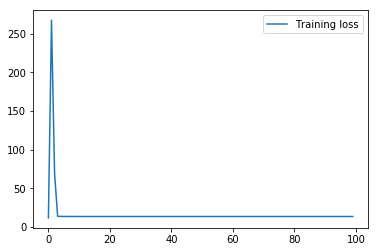

In [12]:
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    try:
        plt.plot(hist, label="Training loss")
        plt.legend()
        plt.show()
        fig00.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_error.png'),dpi=150)
    except:
        print('Model is reloaded instead of trained!')

In [13]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    
    # error score for temporal-spatial fields, without keeping spatial pattern
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        It calculates RMSE over the domain, not over time. The spatial structure
        will not be kept.
        Parameter
        ----------------------
        x: input time series with the shape [time, lat, lon]
        """
        x_series = x.reshape(x.shape[0],-1)
        y_series = y.reshape(y.shape[0],-1)
        rmse = np.sqrt(np.mean((x_series - y_series)**2,1))
        rmse_std = np.sqrt(np.std((x_series - y_series)**2,1))
    
        return rmse, rmse_std
    
    # error score for temporal-spatial fields, keeping spatial pattern
    def MAE(x,y):
        """
        Calculate the MAE. x is input series and y is reference series.
        It calculate MAE over time and keeps the spatial structure.
        """
        mae = np.mean(np.abs(x-y),0)
        
        return mae

*******************  evaluation matrix  *********************


In [14]:
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)

In [15]:
def week2month(series, m):
    """
    Select certain month from yearly data at weekly resolution.
    Parameters
    ----------
    series : array-like
        Three-dimensional numeric arrays with time as the first dimenison [time, lat, lon]
    m: int
        Month (from 1 to 12).
    """
    time_year, lat, lon = series.shape
    time_month = time_year // 12
    series_month = np.zeros((time_month, lat, lon), dtype=float)
    series_month[::4,:,:] = series[(m-1)*4::48,:,:]
    series_month[1::4,:,:] = series[(m-1)*4+1::48,:,:]
    series_month[2::4,:,:] = series[(m-1)*4+2::48,:,:]
    series_month[3::4,:,:] = series[(m-1)*4+3::48,:,:]
    
    return series_month

In [27]:
print(sic_exp_norm.shape)
print(pred_base_sic.shape)
print(lead_pred_sic.shape)
print(sequence_len-test_year*12*4 + 96)
print(i)
print(sequence_len-test_year*12*4 + step)
print(month_exp.shape)

(576, 20, 56)
(480, 20, 56)
(96, 4, 20, 56)
576
577
574
(576, 20, 56)


In [16]:
    %%time
    #################################################################################
    ########  operational lead time dependent prediction with testing data   ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    print ('************  the last {} years of total time series are treated as test data  ************'.format(test_year))
    # time series before test data
    pred_base_sic = sic_exp_norm[:-test_year*12*4,:,:]
    # predict x steps ahead
    step_lead = 4 # unit week
    # create a matrix for the prediction
    lead_pred_sic = np.zeros((test_year*12*4,step_lead,height,width),dtype=float) # dim [predict time, lead time, lat, lon]
    # start the prediction loop
    for step in range(test_year*12*4):
        # Clear stored gradient
        model.zero_grad()
        # Don't do this if you want your LSTM to be stateful
        # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
        # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
        # model.hidden = model.init_hidden()
        # based on the design of this module, the hidden states and cell states are initialized when the module is called.
        for i in np.arange(1,sequence_len-test_year*12*4 + step + step_lead,1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
            #############################################################################
            ###############           before time of prediction           ###############
            #############################################################################
            if i <= (sequence_len-test_year*12*4 + step):
                # create variables
                x_input = np.stack((sic_exp_norm[i-1,:,:],
                                    month_exp[i-1,:,:])) #vstack,hstack,dstack
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False)
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the real prediction after the time of prediction
                if i == (sequence_len-test_year*12*4 + step):
                    lead = 0
                    # GPU data should be transferred to CPU
                    lead_pred_sic[step,0,:,:] = last_pred[0,0,:,:].data.numpy()
            #############################################################################
            ###############            after time of prediction           ###############
            #############################################################################
            else:
                lead += 1
                # prepare predictor
                # use the predicted data to make new prediction
                x_input = np.stack((lead_pred_sic[step,i-(sequence_len-test_year*12*4 + step +1),:,:],
                                    month_exp[i-1,:,:])) #vstack,hstack,dstack             
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False)
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the prediction
                lead_pred_sic[step,lead,:,:] = last_pred[0,0,:,:].data.numpy()

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
************  the last 2 years of total time series are treated as test data  ************
CPU times: user 5min 2s, sys: 1min 25s, total: 6min 28s
Wall time: 3min 16s


*******************  Predicted Ice Extent  **********************


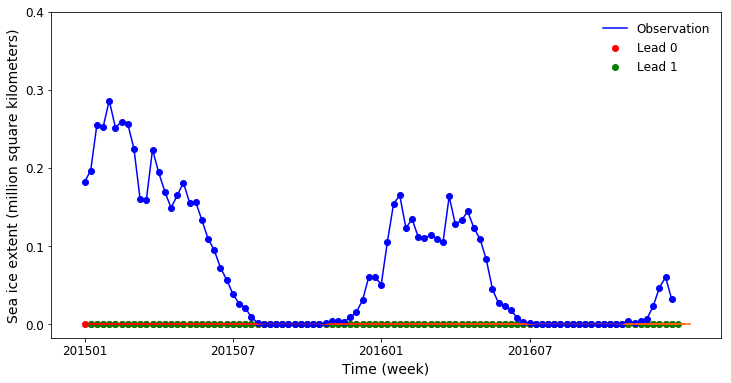

*******************  Prediction Ice Distribution  **********************
###   MAE for all months during testing period   ###
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


ValueError: could not convert string to float: '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Maps/Barents/Demo/spatial_sic_mae_avg_test.png'

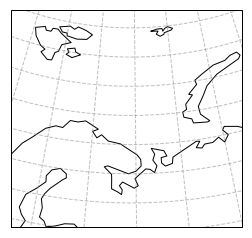

In [17]:
    #################################################################################
    ########        visualization of lead time dependent prediction          ########
    #################################################################################
    index_plot = np.arange(test_year*12*4)
    index_plot_step = np.arange(test_year*12*4+1)
    year_index = np.arange(2015,2017,1)
    # repeat climatology as reference
    #climatology = np.tile(seansonal_cycle_SIC,len(year_ERAI))
    # create index
    # correction for float point at 0
    lead_pred_sic[lead_pred_sic<0] = 0
    # extend the dimension of sea ice mask
    sea_ice_mask_test = np.repeat(sea_ice_mask_barents[np.newaxis,:,:],test_year*48,0)
    # correct the land cells in the prediction
    for i in range(step_lead):
        lead_pred_sic[:,i,:,:] = lead_pred_sic[:,i,:,:] * sea_ice_mask_test
    print ("*******************  Predicted Ice Extent  **********************")
    # include text box in the figure
    #text_content = '$RMSE=%.3f$ ' % (error_pred)
    sic_extend_lead = np.sum(np.sum(lead_pred_sic,3),2)
    colormap=cm.autumn(range(test_year*12*4))
    
    fig0 = plt.figure(figsize=(12,6))
    for i in range(test_year*12*4):
        plt.plot(np.arange(index_plot[i],index_plot[i]+step_lead), sic_extend_lead[i,:]* sic_max / 1E+6, color=colormap[i])
    plt.scatter(index_plot, sic_extend_lead[:,0]* sic_max/ 1E+6, color='r', label="Lead 0")
    plt.scatter(index_plot_step[1:], sic_extend_lead[:,1]* sic_max/ 1E+6, color='g', label="Lead 1")
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1)* sic_max/ 1E+6, 'b', label="Observation")
    plt.scatter(index_plot,np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1)* sic_max/ 1E+6, color='b')
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    plt.xlabel('Time (week)',fontsize = 14)
    plt.ylabel('Sea ice extent (million square kilometers)',fontsize = 14)
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201501', '201507', '201601', '201607']),
               fontsize = 12)
    plt.yticks(np.arange(0,0.5,0.1), fontsize = 12)
    plt.legend(frameon=False, loc=1, prop={'size': 12})
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig0.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_lead_test.png'),dpi=150)
    
    print ("*******************  Prediction Ice Distribution  **********************")
    mae = MAE(lead_pred_sic[:,0,:,:],sic_exp_norm[-test_year*12*4:,:,:])
    print("###   MAE for all months during testing period   ###")
    label = 'MAE (square kilometers)'
    ticks = [i for i in np.linspace(0,200,11)]
    deepclim.visual.plots.geograph(latitude_ERAI[12:32], longitude_ERAI[264:320],
                                   mae * sic_max, label, ticks,
                                   os.path.join(output_path,'spatial_sic_mae_avg_test.png'),
                                   boundary='Barents_Polar', colormap='Blues')
    
    mae_persist = MAE(sic_exp_norm[-test_year*12*4-1:-1,:,:], sic_exp_norm[-test_year*12*4:,:,:])
    print("###   Difference of MAE for all months during testing period for predictions and persistence  ###")
    label = 'MAE (square kilometers)'
    ticks = [i for i in np.linspace(-50,50,11)]
    deepclim.visual.plots.geograph(latitude_ERAI[12:32], longitude_ERAI[264:320],
                                   (mae - mae_persist) * sic_max,label, ticks,
                                    os.path.join(output_path,'spatial_sic_mae_avg_test-persist.png'),
                                    boundary='Barents_Polar',colormap='coolwarm')
    
    print("###   MAE for each month during testing period   ###")
    ticks = [i for i in np.linspace(0,200,11)]
    for i in np.arange(1,13,1):
        # 48 weeks in total
        mae_monthly = MAE(week2month(lead_pred_sic[:,0,:,:],i), week2month(sic_exp_norm[-test_year*12*4:,:,:],i))
        deepclim.visual.plots.geograph(latitude_ERAI[12:32], longitude_ERAI[264:320],
                                       mae_monthly * sic_max, label, ticks,
                                       os.path.join(output_path,'spatial_sic_mae_avg_test_month_{}.png'.format(i)),
                                       boundary='Barents_Polar',colormap='Blues')
                                       
    print("###   Difference of MAE for each month during testing period and persistence  ###")
    ticks = [i for i in np.linspace(-50,50,11)]
    for i in np.arange(1,13,1):
        # 48 weeks in total
        mae_monthly = MAE(week2month(lead_pred_sic[:,0,:,:],i), week2month(sic_exp_norm[-test_year*12*4:,:,:],i))
        mae_persist_monthly = MAE(week2month(sic_exp_norm[-test_year*12*4-1:-1,:,:],i),
                                  week2month(sic_exp_norm[-test_year*12*4:,:,:],i))
        deepclim.visual.plots.geograph(latitude_ERAI[12:32], longitude_ERAI[264:320],
                                       (mae_monthly - mae_persist_monthly) * sic_max, label, ticks,
                                       os.path.join(output_path,'spatial_sic_mae_avg_test-persist_month_{}.png'.format(i)),
                                       boundary='Barents_Polar', colormap='coolwarm')
        
    print ("*******************  histrogram of the values **********************")
    fig3 = plt.figure(figsize=(5,5))
    # make the probability density sum to be 1
    weights_pred = np.ones_like(lead_pred_sic[:,0,:,:].flatten())/float(len(lead_pred_sic[:,0,:,:].flatten()))
    weights_obs = np.ones_like(sic_exp_norm[-test_year*12*4:,:,:].flatten())/float(len(sic_exp_norm[-test_year*12*4:,:,:].flatten()))
    weight_persist = np.ones_like(sic_exp_norm[-test_year*12*4-1:-1,:,:].flatten())/float(len(sic_exp_norm[-test_year*12*4-1:-1,:,:].flatten()))
    plt.hist(np.vstack((lead_pred_sic[:,0,:,:].flatten(),
                        sic_exp_norm[-test_year*12*4:,:,:].flatten(),
                        sic_exp_norm[-test_year*12*4-1:-1,:,:].flatten())).T,
             bins=10, range=(0.0,1.0), weights=np.vstack((weights_pred,weights_obs,weight_persist)).T,
             density=False, color=['r','b','g'], alpha=0.75, label=['Pred','Obs','Persist'])
    plt.xlabel('Normalized sea ice concentration', fontsize = 12)
    plt.ylabel('Probability Density', fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    axes = plt.gca()
    #axes.set_ylim(0,0.9)
    plt.legend()
    plt.show()
    fig3.savefig(os.path.join(output_path,'sic_ERAI_LSTM_pred_lead_test_hist.png'),dpi=150)
    
    print ("*******************  scatter obs data v.s. testing data **********************")
    fig4 = plt.figure(figsize=(5,5))
    plt.scatter(np.sort(lead_pred_sic[:,0,:,:]), np.sort(sic_exp_norm[-test_year*12*4:,:,:]))
    plt.xlabel('Prediction', fontsize = 12)
    plt.ylabel('Observation', fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    axes = plt.gca()
    axes.set_xlim(0,1.0)
    axes.set_ylim(0,1.0)
    axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c="r")
    #plt.plot(np.arange(0,1.0,11),np.arange(0,1.0,11),'r')
    #plt.legend()
    plt.show()
    fig4.savefig(os.path.join(output_path,'sic_ERAI_LSTM_pred_lead_test_scatter.png'),dpi=150)
    
    print ("*******************  quantile mapping obs data v.s. testing data **********************")
    # Draw quantile-quantile plot
    plt.figure(figsize=(5,5))
    qqplot(np.sort(lead_pred_sic[:,0,:,:]), np.sort(sic_exp_norm[-test_year*12*4:,:,:]),
           c='r', alpha=0.5, edgecolor='k')
    plt.xlabel('Prediction', fontsize = 12)
    plt.ylabel('Observation', fontsize = 12)
    axes = plt.gca()
    axes.set_xlim(0,1.0)
    axes.set_ylim(0,1.0)
    axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c="b", alpha=0.5)
    #plt.title('Quantile Mapping')
    plt.savefig(os.path.join(output_path,'sic_ERAI_LSTM_pred_lead_test_quantile.png'),dpi=150)
    plt.show()
    plt.close()

In [ ]:
    #################################################################################
    ########                performance evaluation with RMSE                 ########
    ########              RMSE over time, and sum over domain                ########
    #################################################################################
    sequence_len, height, width = sic_exp_norm.shape
    print('##############################################################')
    print('############   start prediction with climatology  ############')
    print('##############################################################')
    # compute climatology
    climatology = np.zeros((48, height, width),dtype=float)
    for i in range(48):
        climatology[i,:,:] = np.mean(sic_exp_norm[i::48,:,:],axis=0)
    # repeat this climatology and calculate the RMSE
    climatology_seq = np.tile(climatology,(test_year,1,1))
    RMSE_climatology, RMSE_climatology_std  = RMSE(climatology_seq * sic_max,sic_exp_norm[-test_year*12*4:,:,:] * sic_max)
    RMSE_climatology = np.mean(RMSE_climatology)
    RMSE_climatology_std = np.mean(RMSE_climatology_std)
    print('##############################################################')
    print('############   start prediction with persistence  ############')
    print('##############################################################')
    RMSE_persist_0, RMSE_persist_0_std = RMSE(sic_exp_norm[-test_year*12*4-1:-1,:,:] * sic_max,
                                              sic_exp_norm[-test_year*12*4:,:,:] * sic_max)
    RMSE_persist_1, RMSE_persist_1_std = RMSE(sic_exp_norm[-test_year*12*4-1:-2,:,:] * sic_max,
                                              sic_exp_norm[-test_year*12*4+1:,:,:] * sic_max)
    RMSE_persist_2, RMSE_persist_2_std = RMSE(sic_exp_norm[-test_year*12*4-1:-3,:,:] * sic_max,
                                              sic_exp_norm[-test_year*12*4+2:,:,:] * sic_max)
    RMSE_persist_3, RMSE_persist_3_std = RMSE(sic_exp_norm[-test_year*12*4-1:-4,:,:] * sic_max,
                                              sic_exp_norm[-test_year*12*4+3:,:,:] * sic_max)
    print('##############################################################')
    print('########   start prediction with linear regression   #########')
    print('##############################################################')
    
    print('#################################################################################')
    print('############   evaluation and statistical matrix for the entire year ############')
    print('#################################################################################')
    RMSE_ConvLSTM_0, RMSE_ConvLSTM_0_std = RMSE(lead_pred_sic[:,0,:,:] * sic_max,
                                                sic_exp_norm[-test_year*12*4:,:,:] * sic_max)
    RMSE_ConvLSTM_1, RMSE_ConvLSTM_1_std = RMSE(lead_pred_sic[:-1,1,:,:] * sic_max,
                                                sic_exp_norm[-test_year*12*4+1:,:,:] * sic_max)
    RMSE_ConvLSTM_2, RMSE_ConvLSTM_2_std = RMSE(lead_pred_sic[:-2,2,:,:] * sic_max,
                                                sic_exp_norm[-test_year*12*4+2:,:,:] * sic_max)
    RMSE_ConvLSTM_3, RMSE_ConvLSTM_3_std = RMSE(lead_pred_sic[:-3,3,:,:] * sic_max,
                                                sic_exp_norm[-test_year*12*4+3:,:,:] * sic_max)
    print("*******************     Lead time 0     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_0),"+-",np.mean(RMSE_ConvLSTM_0_std))
    print("Mean RMSE with testing data - Climatology")
    print(RMSE_climatology,"+-",RMSE_climatology_std)
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_0),"+-",np.mean(RMSE_persist_0_std))
    print("*******************     Lead time 1     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_1),"+-",np.mean(RMSE_ConvLSTM_1_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_1),"+-",np.mean(RMSE_persist_1_std))
    print("*******************     Lead time 2     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_2),"+-",np.mean(RMSE_ConvLSTM_2_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_2),"+-",np.mean(RMSE_persist_2_std))
    print("*******************     Lead time 3     *******************")
    print("Mean RMSE with testing data - ConvLSTM")
    print(np.mean(RMSE_ConvLSTM_3),"+-",np.mean(RMSE_ConvLSTM_3_std))
    print("Mean RMSE with testing data - Persistence")
    print(np.mean(RMSE_persist_3),"+-",np.mean(RMSE_persist_3_std))
    print('##############################################################')
    print('############           create a txt file          ############')
    print('##############################################################')
    f = open(os.path.join(output_path,"report_rmse_pred.txt"),"w+")
    f.write("############   evaluation of prediction   ############\n")
    f.write("############   Total RMSE with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_0),np.mean(RMSE_ConvLSTM_0_std)))
    f.write("RMSE - Climatology    {} + - {}\n".format(RMSE_climatology, RMSE_climatology_std))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_0),np.mean(RMSE_persist_0_std)))
    f.write("*******************     Lead time 1     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_1),np.mean(RMSE_ConvLSTM_1_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_1),np.mean(RMSE_persist_1_std)))
    f.write("*******************     Lead time 2     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_2),np.mean(RMSE_ConvLSTM_2_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_2),np.mean(RMSE_persist_2_std)))
    f.write("*******************     Lead time 3     *******************\n")
    f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(RMSE_ConvLSTM_3),np.mean(RMSE_ConvLSTM_3_std)))
    f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(RMSE_persist_3),np.mean(RMSE_persist_3_std)))
    f.write("-\n")
    f.write("-\n")
    f.write("-\n")
    f.write("############   Monthly RMSE with testing data   ############\n")
    f.write("*******************     Lead time 0     *******************\n")
    for i in np.arange(1,13,1):
        ConvLSTM_monthly_series = week2month(lead_pred_sic[:,0,:,:], i)
        persist_monthly_series = week2month(sic_exp_norm[-test_year*12*4-1:-1,:,:], i)
        climatology_monthly_series = week2month(climatology_seq, i)
        truth_monthly_series = week2month(sic_exp_norm[-test_year*12*4:,:,:], i)
        
        rmse_ConvLSTM_monthly, rmse_ConvLSTM_monthly_std = RMSE(ConvLSTM_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_persist_monthly, rmse_persist_monthly_std = RMSE(persist_monthly_series * sic_max,truth_monthly_series * sic_max)
        rmse_climatology_monthly, rmse_climatology_monthly_std = RMSE(climatology_monthly_series * sic_max,truth_monthly_series * sic_max)
        
        print("*******************    {}     *******************".format(i))
        print("RMSE - ConvLSTM       {} + - {}".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        print("RMSE - Climatology    {} + - {}".format(np.mean(rmse_climatology_monthly), np.mean(rmse_climatology_monthly_std)))
        print("RMSE - Persistence    {} + - {}".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
        f.write("*******************    {}     *******************\n".format(i))
        f.write("RMSE - ConvLSTM       {} + - {}\n".format(np.mean(rmse_ConvLSTM_monthly), np.mean(rmse_ConvLSTM_monthly_std)))
        f.write("RMSE - Climatology    {} + - {}\n".format(np.mean(rmse_climatology_monthly), np.mean(rmse_climatology_monthly_std)))
        f.write("RMSE - Persistence    {} + - {}\n".format(np.mean(rmse_persist_monthly), np.mean(rmse_persist_monthly_std)))
    #f.write("*******************     Lead time 6     *******************\n")
    f.close()

In [ ]:
    #################################################################################
    ########        visualization of lead time dependent prediction          ########
    #################################################################################
    year_index = np.arange(2013,2017,1)
    index_plot = np.arange(test_year*12*4)
    #index_plot = np.arange(10)

    # first construct iris coordinate
    lat_iris = iris.coords.DimCoord(latitude_ERAI[12:36], standard_name='latitude', long_name='latitude',
                                    var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude_ERAI[264:320], standard_name='longitude', long_name='longitude',
                                    var_name='lon', units='degrees')
    # take obs sic from certain period
    sic_select_norm = sic_exp_norm[-test_year*12*4:,:,:]
    sic_select_bin = sic_exp_bin[-test_year*12*4:,:,:]
    sic_persist_norm = sic_exp_norm[-test_year*12*4-1:-1,:,:]
    
    for i in index_plot:
        year = year_index[i//48]
        month = i//4 - (year-2013)*12 + 1
        week = i - (month-1)*4 - (year-2013) * 48 + 1
        # figure
        fig = plt.figure(figsize=(8,6.6))
        fig.suptitle('ConvLSTM SIC prediction year year {} month {} week {}'.format(year, month, week))
        
        # submap 1 - configure map
        ax1 = plt.subplot(2, 2, 1, projection=ccrs.EquidistantConic(central_longitude=39.0, central_latitude=72.0))
        ax1.set_extent([16,60,60,82],ccrs.PlateCarree()) # W:18 E:60 S:64 N:80    
        ax1.set_aspect('1')
        ax1.coastlines()
        gl = ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        # assemble cube iris
        cube_iris = iris.cube.Cube(lead_pred_sic[i,0,:,:], long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)])
        # other set-ups
        ticks = [i for i in np.linspace(0.0,1.0,11)]
        label = 'Pred SIC'
        # make plots
        cs = iplt.contourf(cube_iris, cmap='Blues',levels=ticks, extend='both', vmin=ticks[0], vmax=ticks[-1])
        cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05)#, format="%.1f")
        cbar.set_label(label,size = 9)
        cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
        
        # submap 2 - configure map
        ax2 = plt.subplot(2, 2, 2, projection=ccrs.EquidistantConic(central_longitude=39.0, central_latitude=72.0))
        ax2.set_extent([16,60,60,82],ccrs.PlateCarree()) # W:18 E:60 S:64 N:80    
        ax2.set_aspect('1')
        ax2.coastlines()
        gl = ax2.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        # assemble cube iris
        cube_iris = iris.cube.Cube(sic_select_norm[i,:,:], long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)])
        # other set-ups
        ticks = [i for i in np.linspace(0.0,1.0,11)]
        label = 'Obs SIC'
        # make plots       
        cs = iplt.contourf(cube_iris, cmap='Blues',levels=ticks, extend='both', vmin=ticks[0], vmax=ticks[-1])
        cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05)#, format="%.1f")
        cbar.set_label(label,size = 9)
        cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)

        # adjust location of subplots
        plt.subplots_adjust(left= 0.05, right= 0.95, bottom=0.03, top=0.93, wspace = 0.01, hspace = 0.03)
        
        fig.savefig(os.path.join(output_path,'sic_pred_obs_anime_week_{:04d}.png'.format(i)), dpi=120)
        iplt.show()
        plt.close(fig)

In [ ]:
    #################################################################################
    ########                       Animation Generator                       ########
    #################################################################################
    #For long movie (save memory)
    test_year = 2
    index_plot = np.arange(test_year*12*4)
    # output path
    #output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\Maps\\Barents\\Anime'
    with imageio.get_writer(os.path.join(output_path, 'ConvLSTM_sic.gif'), mode='I',duration=1.0) as writer:
        for i in index_plot:
            if i%10 == 0:
                print("step {}".format(i))
            images = imageio.imread(os.path.join(output_path,'sic_pred_obs_anime_week_{:04d}.png'.format(i)))
            writer.append_data(images)
    writer.close()
    # for short gif
#     images = []
#     for i in index_plot:
#         images.append(imageio.imread(os.path.join(output_path,'sic_pred_obs_anime_week_{}.png'.format(i))))
#     imageio.mimsave(os.path.join(output_path, 'ConvLSTM_sic.gif'), images, duration=0.3)    